<a href="https://colab.research.google.com/github/bieri2/ATMS597_Project5_GroupB/blob/master/ATMS597_Project5_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import brier_score_loss
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [228]:
# Read data
all_data = pd.read_csv('/content/drive/My Drive/Project5_Data/all_data_KDSM_qc.csv').set_index('date_time')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Codes** \\
**Rain**: RA, FZRA, TSRA (value 0) \\
**Snow**: SN, SNDZ (value 1)

In [0]:
where_rasn = [i for i,x in enumerate(all_data['current_wx1'].to_list()) if ('RA' in x) | ('SN' in x)]
rasn = all_data.iloc[where_rasn]

In [0]:
rasn.index = pd.to_datetime(rasn.index)

In [0]:
exclude_both = [i for i,x in enumerate(rasn['current_wx1'].to_list()) if 'SNRA' not in x]
rasn = rasn.iloc[exclude_both]

In [232]:
set(rasn['current_wx1'].to_list())

{'+FZRA',
 '+RA',
 '+SN',
 '+TSRA',
 '-FZRA',
 '-RA',
 '-SN',
 '-SNDZ',
 '-TSRA',
 'FZRA',
 'RA',
 'SN',
 'TSRA'}

In [0]:
rasn['is_snowing'] = 0

In [234]:
where_sn = [i for i,x in enumerate(rasn['current_wx1'].to_list()) if 'SN' in x]
rasn['is_snowing'][where_sn] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
rasn['day_of_year'] = rasn.index.dayofyear

In [0]:
lc_int = {'OVC':1, 'BKN':0.7, 'FEW':0.2, 'SCT':0.4,'VV':0.5, 'CLR':0}
rasn['low_cloud_type'] = rasn['low_cloud_type'].map(lc_int) 

In [0]:
features = ['air_temperature', 'wind_speed', 'wind_direction',  
            'low_cloud_level', 'cloud_coverage', 
            'air_temperature', 'dew_point_temperature', 
            'altimeter', 'eastward_wind', 
            'northward_wind', 'day_of_year',
            'low_cloud_type', 'is_snowing']

rasn_sub = rasn.dropna(subset = features)
trainX, validX, trainy, validy = train_test_split(rasn_sub[features[:-1]], rasn_sub['is_snowing'], 
                                                  test_size = 0.3, random_state = 42)

In [0]:
dtc    = tree.DecisionTreeClassifier()
model  = dtc.fit(trainX, trainy)
prediction = model.predict(validX)

In [0]:
valid_prob = model.predict_proba(validX)
train_prob = model.predict_proba(trainX)

In [0]:
def get_climo(y, shape):
    climo = (np.size((y == 1).values.nonzero()))/float(np.size(y))
    prob  = np.zeros((shape))
    prob[:,0] = 1-climo
    prob[:,1] = climo

    return prob

In [0]:
train_climo_prob = get_climo(trainy, train_prob.shape)
valid_climo_prob = train_climo_prob[:47547, :]

In [0]:
bss_train = 1 - (brier_score_loss(trainy, train_prob[:,1])/brier_score_loss(trainy, train_climo_prob[:,1]))
bss_valid = 1 - (brier_score_loss(validy, valid_prob[:,1])/brier_score_loss(validy, valid_climo_prob[:,1]))

In [243]:
print('Training Brier skill score: '   + str(bss_train))
print('Validation Brier skill score: ' + str(bss_valid))

Training Brier skill score: 0.9997886184920601
Validation Brier skill score: 0.9742434143850809


In [0]:
fpr, tpr, thresholds = roc_curve(validy, valid_prob[:,1])

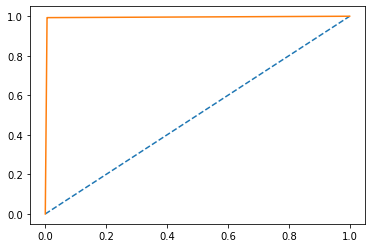

In [245]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()